## Setup

In [1]:
from __future__ import division, print_function, absolute_import

In [2]:
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
sns.set()

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
from lsst.sims.catalogs.measures.instance import InstanceCatalog
import lsst.sims.catUtils.baseCatalogModels as bcm
from lsst.sims.catalogs.generation.db import CatalogDBObject, DBObject
from lsst.sims.catUtils.baseCatalogModels.GalaxyModels import GalaxyTileObj, GalaxyObj
from lsst.sims.utils import ObservationMetaData

/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


## Catalogs

Usual observation MetaData, for galaxy Tile. Note that this is shifted from the galaxy Base by a simple rotation along phi of size 2 degrees. We consider two Observation Meta Data boxes one which gives the base tile and one which is 4 degrees South. 

In [5]:
observerMetaData = ObservationMetaData(boundType='box',
                                  pointingRA=2.,
                                  pointingDec=0.,
                                  boundLength=0.1)

In [6]:
observerMetaData_1 = ObservationMetaData(boundType='box',
                                  pointingRA=2.,
                                  pointingDec=-4.,
                                  boundLength=0.1)

In [7]:
class galCopy(InstanceCatalog):
    column_outputs = ['galtileid', 'raJ2000', 'decJ2000', 'redshift', 'mass_stellar', 'absmag_r_total']#, 'a_d', 'b_d', 'pa_disk', 'mass_stellar', 'absmag_r_total']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e', 
                        'mass_stellar': '%8e', 'absmag_r_total': '%8e'}

In [8]:
def galIds(tileID, galTileID):
    return galTileID - 100000000* tileID

In [9]:
galaxyTiled = GalaxyTileObj()

/usr/local/manual/anaconda/lib/python2.7/site-packages/sqlalchemy/dialects/mssql/base.py:1294: SAWarning: Did not recognize type 'geography' of column 'geopoint'
  return fn(*arg, **kw)


In [184]:
def myarccos(cosine):
    
    sinhalftheta = np.sqrt(0.5*(1.0 - cosine))
    return 2.0 *np.arcsin(sinhalftheta)

In [213]:
theta = 4.0e-9

In [214]:
#theta = 2*np.arcsin(np.sqrt(0.5*(1 - theta)))

In [215]:
np.cos(theta)

1.0

In [216]:
2*np.arcsin(np.sqrt(0.5*(1 - np.cos(theta))))

0.0

In [219]:
lim = 1.0e-3/60./ 60. * np.pi/180.

In [222]:
np.arccos(np.cos(lim) - 1.) - np.pi/2.

0.0

In [227]:
import palpy

In [ ]:
palpy.dsep()

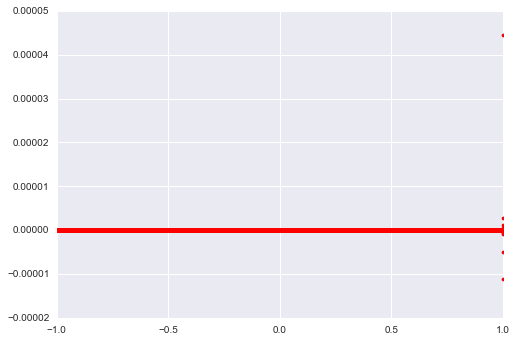

In [194]:
fig, ax = plt.subplots()
rads = np.arange(0., np.pi, 0.000001)
cosvals =  np.cos(rads)
theta = myarccos(cosvals)
phis = np.arccos(cosvals)
ax.plot(cosvals, np.arccos(cosvals)/rads - 1.,'.')
ax.plot(cosvals, theta/rads - 1.,'r.')
#ax.set_xscale('log')

In [191]:
phis

array([  0.00000000e+00,   1.00004445e-06,   1.99997788e-06, ...,
         3.14159000e+00,   3.14159100e+00,   3.14159200e+00])

In [187]:
theta

array([  0.00000000e+00,   1.00004445e-06,   1.99997788e-06, ...,
         3.14159000e+00,   3.14159100e+00,   3.14159200e+00])

In [188]:
rads

array([  0.00000000e+00,   1.00000000e-06,   2.00000000e-06, ...,
         3.14159000e+00,   3.14159100e+00,   3.14159200e+00])

In [250]:
def angSep( df1 , df2,  theta, phi):
    th1 = df1[theta].values
    th2 = df2[theta].values
    ph1 = df1[phi].values
    ph2 = df2[phi].values
    # Take the dot product
    cos = np.sin(th1)* np.sin(th2)* np.cos(ph1- ph2) + np.cos(th1)*np.cos(th2)
    # Calculate arccos differently to avoid loss of precision
    #sinhalftheta = np.sqrt(0.5*(1.0 - cos))
    #return 2.*(np.arcsin(sinhalftheta))
    return cos, myarccos(cos)

In [269]:
def rotation(df, delta=0):
    """
    delta : int
    """
    d = delta
    delta = np.radians(delta * 4.0)
    cosDelta = np.cos(delta)
    sinDelta = np.sin(delta)
    
    # spherical polar
    df['theta'] = - df['decJ2000'] + np.pi/2.
    df['phi'] = df['raJ2000'] - np.radians(2.)
    sintheta = np.sin(df.theta)
    costheta = np.cos(df.theta)
    cosphi = np.cos(df.phi)
    sinphi = np.sin(df.phi)
    
    zprime =  costheta * cosDelta - sinDelta * sintheta * cosphi
    xprime = sintheta * cosphi * cosDelta + costheta * sinDelta
    yprime = sintheta * sinphi
    
    rlat = np.sqrt(xprime **2. + yprime **2.)
    #rlat = np.sqrt(1.0 - zprime**2)
    #print(min(rlat), max(rlat))
    thetaprime = 'thetaprime_{}'.format(int(d))
    phiprime = 'phiprime_{}'.format(d)
    # df[phiprime] = np.arccos(xprime / rlat) - np.radians(2.)
    df[phiprime] = np.arcsin(yprime / rlat) - np.radians(2.)
    
    #df['x'] = sintheta * cosphi
    #df['y'] = sintheta * sinphi
    #df['z'] = costheta
    #df['xprime'] = xprime
    #df['yprime'] = yprime
    #df['zprime'] = zprime
    #df[thetaprime] = np.arccos(zprime)
    df[thetaprime] = myarccos(zprime)
    #df[thetaprime] = np.arctan(rlat/zprime) 
    #df.thetaprime[df[thetaprime] < 0 ] += np.pi
    #df[thetaprime] = np.arcsin(np.sqrt(xprime**2. + yprime**2))#*np.sign(zprime)
    # df[thetaprime] = np.arcsin(rlat) * np.sign(zprime)

#### On Base Patch

In [44]:
# Read the two tiles into pd.DataFrames

In [51]:
constr='redshift < 0.4'
gBase = galCopy(galaxyTiled, obs_metadata=observerMetaData, constraint=constr)
gBase.write_catalog('gBase.csv')
gBase_df  = pd.read_csv('gBase.csv', delimiter=', ',index_col='#galtileid')
gBase_df.index.name = 'galtileid'
gBase_df.head()

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total
galtileid,,,,,
2209932244,0.034950,-0.000120,0.1995,0.000161,-13.24359
2201788073,0.034923,-0.000554,0.1964,0.002476,-15.88512
2201787850,0.035353,-0.000105,0.1835,0.002417,-15.63991
2200394567,0.035337,-0.000311,0.2112,0.069907,-18.30111
2211503240,0.035103,-0.000191,0.1947,0.000087,-13.10250


In [52]:
gBase_df['id'] = galIds(22, gBase_df.index.values)
gBase_df.set_index('id', inplace=True)
gBase_df.head()

,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total
id,,,,,
9932244,0.034950,-0.000120,0.1995,0.000161,-13.24359
1788073,0.034923,-0.000554,0.1964,0.002476,-15.88512
1787850,0.035353,-0.000105,0.1835,0.002417,-15.63991
394567,0.035337,-0.000311,0.2112,0.069907,-18.30111
11503240,0.035103,-0.000191,0.1947,0.000087,-13.10250


#### On a Tile 4 degrees South

In [53]:
gTile_1 = galCopy(galaxyTiled, obs_metadata=observerMetaData_1, constraint=constr)
gTile_1.write_catalog('gTile_1.csv')
gTile1_df  = pd.read_csv('gTile_1.csv', delimiter=', ', index_col='#galtileid')
gTile1_df.index.name = 'galtileid'
gTile1_df.head()

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total
galtileid,,,,,
2109932244,0.034951,-0.069933,0.1995,0.000161,-13.24359
2101788073,0.034924,-0.070367,0.1964,0.002476,-15.88512
2101787850,0.035354,-0.069918,0.1835,0.002417,-15.63991
2100394567,0.035338,-0.070124,0.2112,0.069907,-18.30111
2111503240,0.035104,-0.070005,0.1947,0.000087,-13.10250


In [54]:
gTile1_df['id'] = galIds(21, gTile1_df.index.values)
gTile1_df.set_index('id', inplace=True)
gTile1_df.rename(columns={'raJ2000':'raJ2000_1', 'decJ2000':'decJ2000_1', 'redshift': 'redshift_1',
                          'mass_stellar':'mass_stellar_1', 'absmag_r_total':'absmag_r_total_1'},
                 inplace=True)
gTile1_df.head()

,raJ2000_1,decJ2000_1,redshift_1,mass_stellar_1,absmag_r_total_1
id,,,,,
9932244,0.034951,-0.069933,0.1995,0.000161,-13.24359
1788073,0.034924,-0.070367,0.1964,0.002476,-15.88512
1787850,0.035354,-0.069918,0.1835,0.002417,-15.63991
394567,0.035338,-0.070124,0.2112,0.069907,-18.30111
11503240,0.035104,-0.070005,0.1947,0.000087,-13.10250


We will merge the two dataFrames, using the ids of the galaxy calculated from the galtileID and the knowledge of the tileID. We look up the tileID for the two tiles as 22, 21 respectively.

In [55]:
merged =  pd.concat([gBase_df, gTile1_df], axis=1)

In [56]:
merged.head()

,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total,raJ2000_1,decJ2000_1,redshift_1,mass_stellar_1,absmag_r_total_1
id,,,,,,,,,,
259,0.033403,0.001036,0.1728,0.009030,-15.33565,0.033400,-0.068777,0.1728,0.009030,-15.33565
371,0.036230,-0.000562,0.0421,0.416331,-19.77124,0.036233,-0.070375,0.0421,0.416331,-19.77124
416,0.034866,0.000352,0.0544,2.260572,-21.29976,0.034866,-0.069461,0.0544,2.260572,-21.29976
1083,0.034761,-0.001270,0.1438,18.788060,-23.22925,0.034761,-0.071083,0.1438,18.788060,-23.22925
1605,0.034287,-0.000954,0.0545,1.074812,-20.27710,0.034285,-0.070767,0.0545,1.074812,-20.27710


How many galaxies in one which are not in the other? Ideally, I think this number should be zero. In the following plot, these points are labelled in blue.

In [57]:
uncommon = merged[merged.isnull().any(axis=1)].copy()

In [58]:
len(uncommon)

4

In [59]:
len(merged)

2284

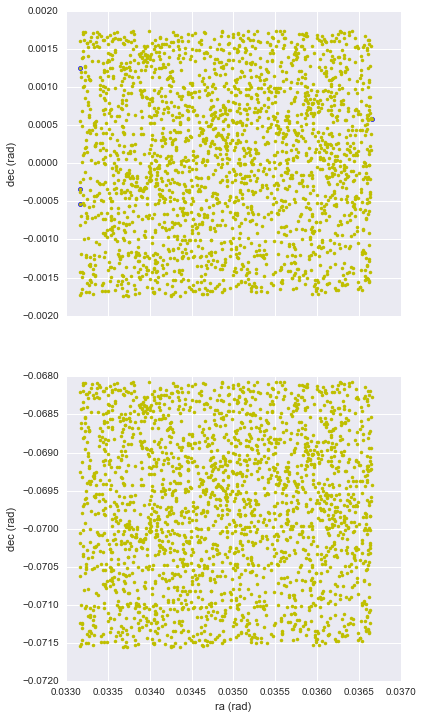

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(6, 12), sharex=True, squeeze=True)
ax[0].plot(merged.raJ2000, merged.decJ2000, 'y.')
ax[0].scatter(uncommon.raJ2000, uncommon.decJ2000, color='b')
ax[1].plot(merged.raJ2000_1, merged.decJ2000_1, 'y.')
ax[1].scatter(uncommon.raJ2000_1, uncommon.decJ2000_1, color='r')
ax[0].set_ylabel('dec (rad)')
ax[1].set_ylabel('dec (rad)')
ax[1].set_xlabel('ra (rad)')

In [61]:
print(len(uncommon)/2., (len(gBase_df) + len(gTile1_df) )/2.)

2.0 2282.0


In [62]:
np.sqrt(2228.)

47.201694884823787

## Tests Galaxies are correctly identified

In [270]:
common = merged[~merged.isnull().any(axis=1)]

In [64]:
np.allclose(common.redshift, common.redshift_1)

True

In [65]:
np.allclose(common.mass_stellar, common.mass_stellar_1)

True

In [66]:
np.allclose(common.absmag_r_total, common.absmag_r_total_1)

True

In [67]:
print(len(common))

2280


## Angular Separations

In [271]:
%timeit rotation(common, delta=1)

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

1 loops, best of 3: 896 ms per loop


In [272]:
NSelect = 1000
sel = np.random.choice(common.index.values, NSelect*2, replace=False)

In [273]:
split_1 = common.ix[sel[:NSelect]]
split_2 = common.ix[sel[NSelect:]]

In [274]:
print(len(split_1), len(split_2))

1000 1000


In [275]:
split_1.head()

,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total,raJ2000_1,decJ2000_1,redshift_1,mass_stellar_1,absmag_r_total_1,theta,phi,phiprime_1,thetaprime_1
id,,,,,,,,,,,,,,
58497,0.035309,0.000608,0.1258,0.166246,-18.91549,0.035309,-0.069205,0.1258,0.166246,-18.91549,1.570188,0.000402,-0.034504,1.640002
3766103,0.034684,0.001007,0.3961,0.024997,-16.78628,0.034684,-0.068806,0.3961,0.024997,-16.78628,1.569789,-0.000222,-0.035129,1.639602
423389,0.035127,-0.000256,0.3699,0.490097,-19.73293,0.035128,-0.070069,0.3699,0.490097,-19.73293,1.571052,0.000220,-0.034686,1.640866
7679642,0.034897,0.000304,0.2736,0.002655,-14.59074,0.034897,-0.069510,0.2736,0.002655,-14.59074,1.570493,-0.000010,-0.034916,1.640306
5563134,0.033876,-0.001283,0.2596,0.003623,-14.84929,0.033874,-0.071096,0.2596,0.003623,-14.84929,1.572080,-0.001030,-0.035939,1.641893


In [276]:
from lsst.sims.utils import haversine

In [277]:
df = pd.DataFrame({'ids_1': split_1.index.values,
                   'ids_2': split_2.index.values,
                   'raJ2000': split_1.raJ2000.values,
                   #'shiftedRA':split_1.shiftedRA.values,
                   'decJ2000':split_1.decJ2000.values,
                   'raJ2000_2': split_2.raJ2000.values,
                   #'shiftedRA_2': split_2.shiftedRA_1.values,
                   'decJ2000_2':split_2.decJ2000.values,
                   'angsep': haversine(split_1.decJ2000.values, split_1.raJ2000.values, split_2.decJ2000.values, 
                                       split_2.raJ2000.values),
                  'angsep_1': haversine(split_1.decJ2000_1.values, split_1.raJ2000_1.values, split_2.decJ2000_1.values, 
                                       split_2.raJ2000_1.values),
                  'angSep': angSep(split_1, split_2, 'theta', 'phi')[1] ,
                  'angSep_1':angSep(split_1, split_2, 'thetaprime_1', 'phiprime_1')[1],
                  'cosval': angSep(split_1, split_2, 'theta', 'phi')[0] ,
                   'cosval_1': angSep(split_1, split_2, 'thetaprime_1', 'phiprime_1')[0] 
                  }
                   #'angsep_1': haversine(split_1.decJ2000_1, split_1.raJ2000_1, split_2.decJ2000_1, split_2.raJ2000_1)}
                  )

In [278]:
df['ratio'] = df.angsep_1/df.angsep 

In [279]:
df['theta_ratio'] = df.angSep_1/df.angSep

In [280]:
df.ratio.describe()

count    1000.000000
mean        1.001247
std         0.000833
min         0.999969
25%         1.000446
50%         1.001256
75%         1.002045
max         1.002547
Name: ratio, dtype: float64

In [281]:
df.theta_ratio.describe()

count    1.000000e+03
mean     1.000000e+00
std      1.281463e-09
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: theta_ratio, dtype: float64

In [282]:
min(df.query('theta_ratio < 0.7').cosval_1 - 1)

ValueError: min() arg is an empty sequence

(0.9999, 1.0001)

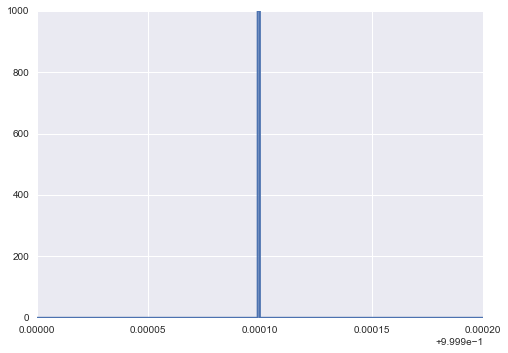

In [283]:
_ = plt.hist(df.cosval_1/np.cos(df.angSep_1), histtype='step', alpha=1, lw=2., bins=np.arange(0.5, 1.5, 0.000001))
plt.xlim(0.9999, 1.0001)

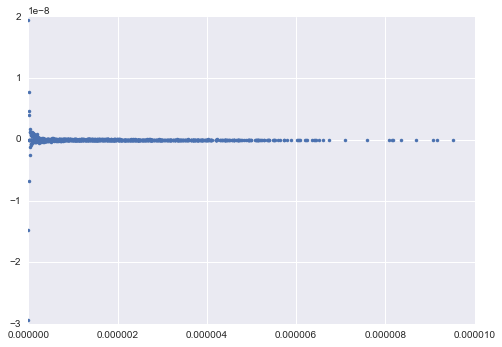

In [284]:
plt.plot(1. - df.cosval, df.angSep_1/df.angSep -1., '.')

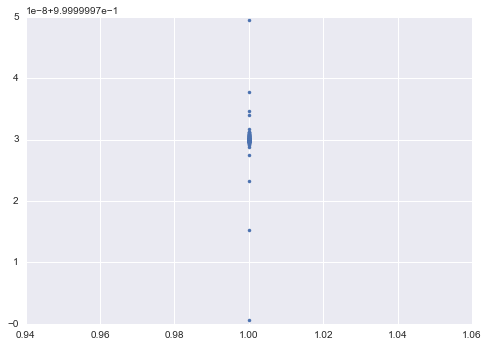

In [285]:
plt.plot(df.cosval_1/df.cosval, df.theta_ratio, '.')

In [286]:
df.ratio.isnull().any()

False

In [287]:
df.theta_ratio.isnull().any()

False

In [288]:
df.theta_ratio.dtype

dtype('float64')

In [289]:
df.head()

,angSep,angSep_1,angsep,angsep_1,cosval,cosval_1,decJ2000,decJ2000_2,ids_1,ids_2,raJ2000,raJ2000_2,ratio,theta_ratio
0,0.002300,0.002300,0.002299,0.002300,0.999997,0.999997,0.000608,-0.001436,58497,8657302,0.035309,0.036364,1.000523,1
1,0.002852,0.002852,0.002851,0.002853,0.999996,0.999996,0.001007,-0.001426,3766103,8808588,0.034684,0.033197,1.000668,1
2,0.002315,0.002315,0.002314,0.002316,0.999997,0.999997,-0.000256,0.001693,423389,3728065,0.035127,0.036376,1.000694,1
3,0.001286,0.001286,0.001286,0.001290,0.999999,0.999999,0.000304,0.000357,7679642,1230723,0.034897,0.036182,1.002410,1
4,0.000347,0.000347,0.000347,0.000347,1.000000,1.000000,-0.001283,-0.001558,5563134,2782218,0.033876,0.034089,1.000976,1


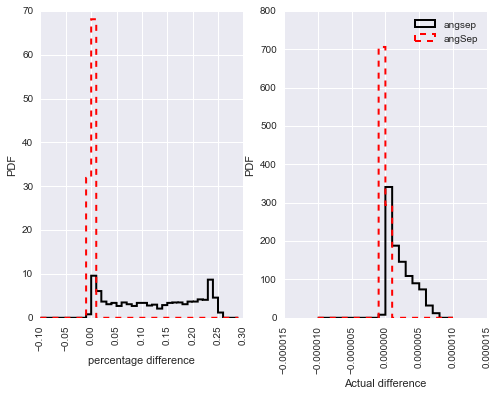

In [292]:
fig, ax = plt.subplots(1, 2, squeeze=True)


_ = ax[0].hist(100.*(df.ratio.values - 1.), bins=np.arange(-0.1, 0.3, 0.01), normed=1,
               histtype='step', alpha=1, lw=2., color='k')
xticks = ax[0].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]

_ = ax[0].hist(100.*(df.theta_ratio.values - 1.), bins=np.arange(-0.1, 0.3, 0.01), 
               normed=1,
               histtype='step', alpha=1, lw=2., color='r', ls='dashed')



# sns.kdeplot(df.ratio - 1., ax=ax)
ax[0].set_xlabel('percentage difference')
ax[0].set_ylabel('PDF')
_ = ax[1].hist((df.ratio.values - 1.)*df.angsep,normed=0, bins=np.arange(-0.00001, 0.00001, 0.000001),
        histtype='step', alpha=1, lw=2., color='k')
_ = ax[1].hist((df.theta_ratio.values - 1.)*df.angSep,normed=0, bins=np.arange(-0.00001, 0.00001, 0.000001),
        histtype='step', alpha=1, lw=2., color='r', ls='dashed')


xticks = ax[1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]


# sns.kdeplot(df.ratio - 1., ax=ax)
ax[1].set_xlabel('Actual difference')
ax[1].set_ylabel('PDF')
#fig.legend(loc='best')
plt.legend()

In [ ]:
plt.plot()

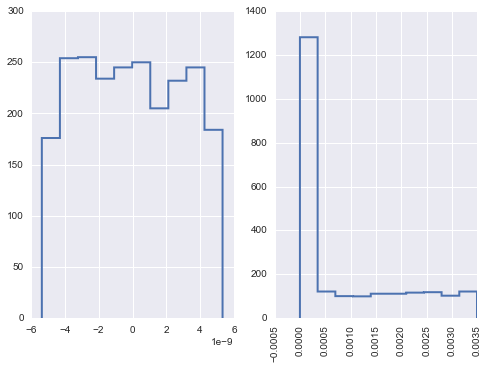

In [84]:
fig, ax = plt.subplots(1,2)
_ = ax[0].hist(common.decJ2000_1 + common.thetaprime_1 - np.pi/2., histtype='step', alpha=1., lw=2.)
_ = ax[1].hist(common.raJ2000_1 + common.phiprime_1, histtype='step', alpha=1., lw=2.)
xticks = ax[1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]




In [85]:
def angSep( df1 , df2,  theta, phi):
    th1 = df1[theta].values
    th2 = df2[theta].values
    ph1 = df1[phi].values
    ph2 = df2[phi].values

    cos = np.sin(th1)* np.sin(th2)* np.cos(ph1- ph2) + np.cos(th1)*np.cos(th2)
    return cos

In [86]:
theta_df= pd.DataFrame({'ids_1': split_1.index.values,
                   'ids_2': split_2.index.values,
                   'raJ2000': split_1.raJ2000.values,
                   #'shiftedRA':split_1.shiftedRA.values,
                   'decJ2000':split_1.decJ2000.values,
                   'raJ2000_2': split_2.raJ2000.values,
                   #'shiftedRA_2': split_2.shiftedRA_1.values,
                   'decJ2000_2':split_2.decJ2000.values,
                   'angSep': angSep(split_1, split_2, 'theta', 'phi') ,
                   'angSep_1':angSep(split_1, split_2, 'thetaprime_1', 'phiprime_1')})

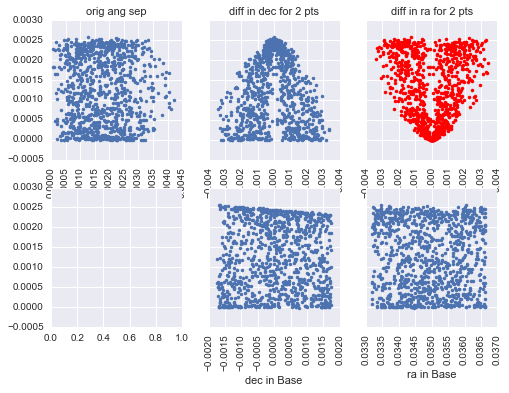

In [87]:
# Use if not using base tile
fig, ax = plt.subplots(2, 3, sharey=True, squeeze=False)
ax[0,0].plot(df.angsep, df.ratio-1, '.')
xticks = ax[0, 0].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 0].set_xlabel('orig ang sep')
ax[0, 0].xaxis.set_label_position('top') 
ax[0, 1].plot(df.decJ2000 - df.decJ2000_2, df.ratio - 1, '.')
ax[0, 1].set_xlabel('diff in dec for 2 pts')
ax[0, 1].xaxis.set_label_position('top') 
xticks = ax[0, 1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 2].plot(df.raJ2000 - df.raJ2000_2, df.ratio - 1, '.r')
xticks = ax[0, 2].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 2].set_xlabel('diff in ra for 2 pts')
ax[0, 2].xaxis.set_label_position('top') 


ax[1, 1].plot(df.decJ2000, df.ratio - 1, '.')
xticks = ax[1, 1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[1, 1].set_xlabel('dec in Base')
ax[1, 2].plot(df.raJ2000, df.ratio - 1, '.')
xticks = ax[1, 2].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[1, 2].set_xlabel('ra in Base')


#ax[1,0].plot(df.angsep, (df.ratio -1)* df.angsep, '.')

## Rotations

In [ ]:
common['theta'] = - common['decJ2000'] + np.pi/2.
common['phi'] = common['raJ2000'] - np.radians(2.)

In [ ]:
common.head()

In [ ]:
def rotation(df, delta=0):
    """
    delta : int
    """
    d = delta
    delta = np.radians(delta * 4.0)
    cosDelta = np.cos(delta)
    sinDelta = np.sin(delta)
    
    df['theta'] = - df['decJ2000'] + np.pi/2.
    df['phi'] = df['raJ2000'] - np.radians(2.)
    sintheta = np.sin(df.theta)
    costheta = np.cos(df.theta)
    cosphi = np.cos(df.phi)
    # sinphi = np.sin(df.phi)
    
    zprime =  costheta * cosDelta - sinDelta * sintheta * cosphi
    xprime = sintheta * cosphi * cosDelta + costheta * sinDelta
    # yprime = sintheta * sinphi
    
    #rlat = np.sqrt(xprime **2. + yprime **2.)
    rlat = np.sqrt(1.0 - zprime**2)
    #print(min(rlat), max(rlat))
    thetaprime = 'thetaprime_{}'.format(int(d))
    phiprime = 'phiprime_{}'.format(d)
    df[phiprime] = np.arccos(xprime / rlat) + np.radians(2.)
    #df['x'] = sintheta * cosphi
    #df['y'] = sintheta * sinphi
    #df['z'] = costheta
    #df['xprime'] = xprime
    #df['yprime'] = yprime
    #df['zprime'] = zprime
    df[thetaprime] = np.arccos(zprime)
    #df[thetaprime] = np.arctan(rlat/zprime) 
    #df.thetaprime[df[thetaprime] < 0 ] += np.pi
    #df[thetaprime] = np.arcsin(np.sqrt(xprime**2. + yprime**2))#*np.sign(zprime)
    # df[thetaprime] = np.arcsin(rlat) * np.sign(zprime)

In [ ]:
rotation(common, delta=1)

In [ ]:
common.head()

In [ ]:
np.radians(2.)

In [ ]:
#common['deltaDec'] = common.decJ2000_1 + common.thetaprime_1 - np.pi/2.

In [ ]:
#common['deltaRA'] = common.raJ2000_1 - common.phiprime_1 - np.radians(2.)

In [ ]:
_ = plt.hist(common.raJ2000_1 - common.phiprime_1, bins=np.arange(-0.004, 0.001, 0.0001), histtype='step', lw=2., alpha=1.,
            normed=1)

In [ ]:
def angSep( df1 , df2,  theta, phi):
    th1 = df1[theta].values
    th2 = df2[theta].values
    ph1 = df1[phi].values
    ph2 = df2[phi].values

    cos = np.sin(th1)* np.sin(th2)* np.cos(ph1- ph2) + np.cos(th1)*np.cos(th2)
    return cos

In [ ]:
split_1.columns

In [ ]:
angSep(split_1, split_2, 'thetaprime_1', 'phiprime_1') - angSep(split_1, split_2, 'theta', 'phi')

In [ ]:
theta_df= pd.DataFrame({'ids_1': split_1.index.values,
                   'ids_2': split_2.index.values,
                   'raJ2000': split_1.raJ2000.values,
                   #'shiftedRA':split_1.shiftedRA.values,
                   'decJ2000':split_1.decJ2000.values,
                   'raJ2000_2': split_2.raJ2000.values,
                   #'shiftedRA_2': split_2.shiftedRA_1.values,
                   'decJ2000_2':split_2.decJ2000.values,
                   'angSep': angSep(split_1, split_2, 'theta', 'phi') ,
                   'angSep_1':angSep(split_1, split_2, 'thetaprime_1', 'phiprime_1')})

In [ ]:
theta_df['ratio'] = theta_df.angSep_1 / theta_df.angSep

In [ ]:
_ = ax[0].hist(100.*(theta_df.ratio - 1), bins=np.arange(-0.1, 0.3, 0.01), normed=1, histtype='step', lw=2., alpha=1., color='r')
_ = ax[1].hist((theta_df.ratio.values - 1.)*theta_df.angSep,normed=1, bins=np.arange(-0.00001, 0.00001, 0.000001),
        histtype='step', alpha=1, lw=2., color='r')

In [ ]:
fig_hist

In [ ]:
common.head()

In [ ]:
# Use shifts to take care of periodicity of ra newar ra=0.
fig, ax = plt.subplots(2, 3, sharey=True, squeeze=False)
ax[0,0].plot(df.angsep, df.ratio-1, '.')
xticks = ax[0, 0].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 0].set_xlabel('orig ang sep')
ax[0, 0].xaxis.set_label_position('top') 
ax[0, 1].plot(df.decJ2000 - df.decJ2000_2, df.ratio - 1, '.')
ax[0, 1].set_xlabel('diff in dec for 2 pts')
ax[0, 1].xaxis.set_label_position('top') 
xticks = ax[0, 1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 2].plot(df.shiftedRA - df.shiftedRA_2, df.ratio - 1, '.r')
xticks = ax[0, 2].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 2].set_xlabel('diff in ra for 2 pts')
ax[0, 2].xaxis.set_label_position('top') 


ax[1, 1].plot(df.decJ2000, df.ratio - 1, '.')
xticks = ax[1, 1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[1, 1].set_xlabel('dec in Base')
ax[1, 2].plot(df.shiftedRA, df.ratio - 1, '.')
xticks = ax[1, 2].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[1, 2].set_xlabel('ra in Base')


#ax[1,0].plot(df.angsep, (df.ratio -1)* df.angsep, '.')

In [ ]:
print(len(df))a


In [ ]:
print(len(merged))

## Scratch

In [ ]:
df.raJ2000.max()

In [ ]:
df.raJ2000.min()

In [ ]:
gTile1_df.raJ2000_1.min()

In [ ]:
gTile1_df.raJ2000_1.max()

In [ ]:
gBase_df.raJ2000.min()

In [ ]:
np.degrees(gBase_df.raJ2000.max())